# Prevendo o customer churn em operações de telecom

In [ ]:
from IPython.display import Image
Image("Churn.png")

A empresa de Telecom precisa de um modelo que preveja se um cliente pode ou não cancelar o seu plano e qual a probabilidade de isso ocorrer, caso ele opte no término do relacionamento comercial.

A variável "churn" será a preditiva, **o valor 0 se o cliente continuará com o serviço, e 1 para o término do mesmo.**

In [28]:
# Importando os pacotes.
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline
from plotnine import *

In [2]:
# Carregando os dados.
df_train = pd.read_csv("Telecom_treino.csv")
df_test = pd.read_csv("Telecom_teste.csv")

### Análise Exploratória

In [3]:
# Visualizando as primeiras linhas.
df_train.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [4]:
#Visualizando os tipos de dados no dataset.
df_train.dtypes

Unnamed: 0                         int64
state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

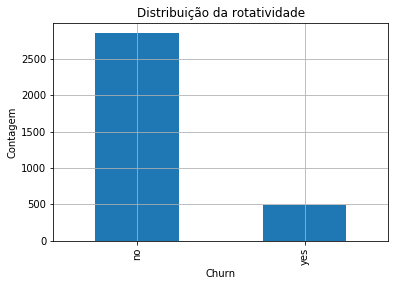

In [5]:
# Distribuição da variável TARGET.
df_train.groupby(by = df_train["churn"]).size().plot.bar()
plt.title("Distribuição da rotatividade")
plt.rc("grid", linestyle = "-", color = "black")
plt.xlabel("Churn")
plt.ylabel("Contagem")
plt.grid()
plt.show()

É muito claro o desequilibrio nos dados, será necessário um balanceamento para que em seguida o dataset sejá apresentado ao modelo.

### Visualizando os Outliers

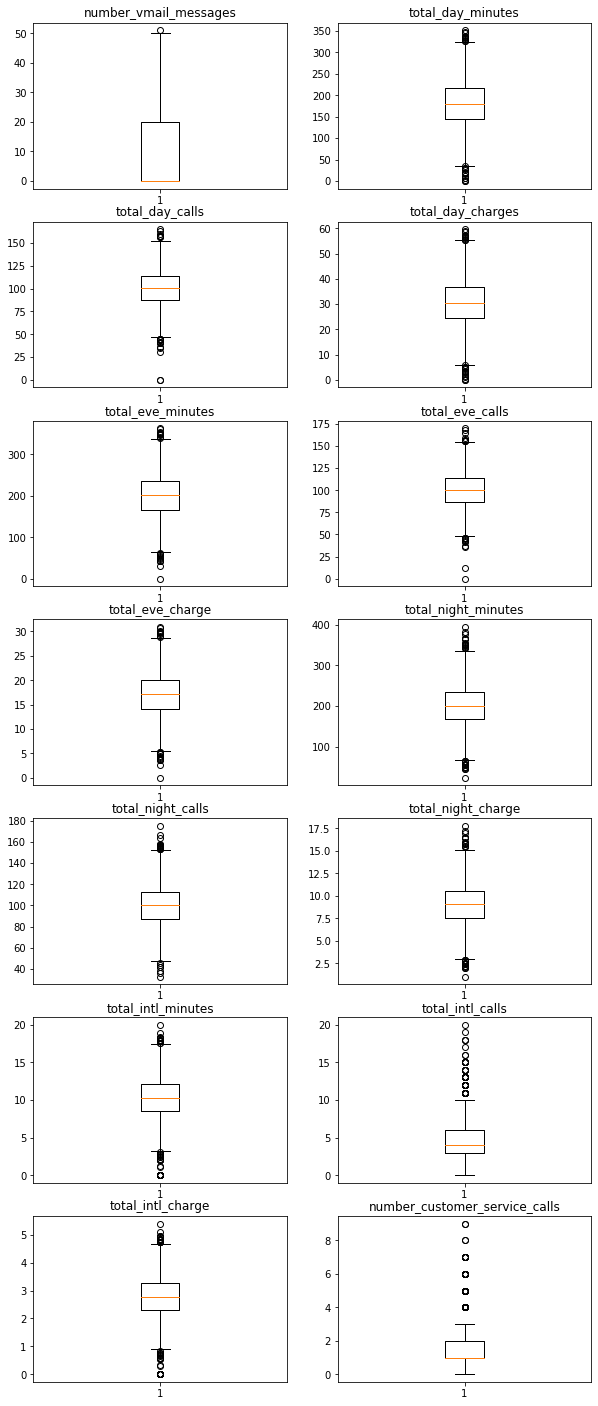

In [41]:
fig, axs = plt.subplots(nrows = 7, ncols = 2, figsize = (10, 25))

axs[0, 0].boxplot(df_train["number_vmail_messages"])
axs[0, 0].set_title("number_vmail_messages")

axs[0, 1].boxplot(df_train["total_day_minutes"])
axs[0, 1].set_title("total_day_minutes")

axs[1, 0].boxplot(df_train["total_day_calls"])
axs[1, 0].set_title("total_day_calls")

axs[1, 1].boxplot(df_train["total_day_charge"])
axs[1, 1].set_title("total_day_charges")

axs[2, 0].boxplot(df_train["total_eve_minutes"])
axs[2, 0].set_title("total_eve_minutes")

axs[2, 1].boxplot(df_train["total_eve_calls"])
axs[2, 1].set_title("total_eve_calls")

axs[3, 0].boxplot(df_train["total_eve_charge"])
axs[3, 0].set_title("total_eve_charge")

axs[3, 1].boxplot(df_train["total_night_minutes"])
axs[3, 1].set_title("total_night_minutes")

axs[4, 0].boxplot(df_train["total_night_calls"])
axs[4, 0].set_title("total_night_calls")

axs[4, 1].boxplot(df_train["total_night_charge"])
axs[4, 1].set_title("total_night_charge")

axs[5, 0].boxplot(df_train["total_intl_minutes"])
axs[5, 0].set_title("total_intl_minutes")

axs[5, 1].boxplot(df_train["total_intl_calls"])
axs[5, 1].set_title("total_intl_calls")

axs[6, 0].boxplot(df_train["total_intl_charge"])
axs[6, 0].set_title("total_intl_charge")

axs[6, 1].boxplot(df_train["number_customer_service_calls"])
axs[6, 1].set_title("number_customer_service_calls")

plt.show()

Os outliers serão ignorados no primeiro momento, ao final será feito um tratamento e comparado com os dados originais.

In [48]:
# Selecionando as colunas com outliers.
total_intl_charge = df_train.iloc[:,18]

In [51]:
# Armazenando a média e o desvio padrão dos dados.
mean = np.mean(total_intl_charge, axis=0)
sd = np.std(total_intl_charge, axis=0)

In [59]:
mean

2.764581458145804

In [60]:
sd

0.7536595269805152

In [57]:
for x in total_intl_charge:
    if (x < mean -2 * sd):
        print(x)

0.95
1.19
0.0
1.19
0.73
1.22
0.0
1.0
0.54
0.0
0.95
0.97
0.0
1.24
1.11
0.97
0.0
0.35
1.08
0.0
1.19
1.13
1.05
1.03
0.0
0.0
0.59
1.08
1.19
1.11
1.11
1.13
1.22
0.0
1.24
1.13
1.13
1.22
0.0
1.22
1.03
0.95
1.0
1.19
0.54
1.22
1.13
1.16
1.03
0.78
0.84
0.89
0.7
0.0
1.24
0.92
0.0
1.0
1.16
1.13
0.0
0.3
0.89
1.16
0.0
0.95
1.22
1.24
1.03
1.03
0.0
1.16
0.0
0.57
1.11
0.78
0.57
1.0
0.65
1.13
0.68
1.05
0.0
0.0


In [58]:
for x in total_intl_charge:
    if (x > mean +2 * sd):
        print(x)

5.4
4.37
4.75
5.1
4.86
4.32
4.32
4.64
4.73
4.73
4.91
4.46
4.4
4.43
4.51
4.29
4.35
4.56
4.59
4.46
4.35
4.62
4.56
4.46
4.86
4.83
4.35
4.56
4.4
4.43
4.67
4.46
4.67
4.97
4.37
4.43
4.81
4.43
4.35
4.43
4.75
4.67
4.59
4.91
4.43
4.86
4.56
4.29
4.35
4.32
4.35
4.59
4.56
4.37
4.94
4.48
4.48
4.29
4.51
4.37
4.73
4.51
4.59
4.81
4.29


In [ ]:
# Valores missing nos dados de treino.
df_train.isnull().sum()

#### Média de chamadas de Atendimento ao cliente por dia

In [ ]:
df_train.groupby("total_day_calls")["number_customer_service_calls"].mean().plot()
plt.title("Média de chamadas de atendimento ao cliente por dia")
plt.rc("grid", linestyle = "-", color = "black")
plt.grid()
plt.show()

#### Média de ligações internacionais por dia

In [ ]:
df_train.groupby(by = "total_day_calls")["total_intl_calls"].mean().plot()
plt.title("Média de ligações internacionais por dia")
plt.rc("grid", linestyle = "-", color = "black")
plt.grid()
plt.show()


#### Média de minutos durante as ligações por período

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 15))

axs[0, 0].hist(df_train["total_day_calls"], color = "cyan", ec = "k")
axs[0, 0].set_title("Ligações no período diurno")


axs[0, 1].hist(df_train["total_day_minutes"], color = "cyan", ec = "k")
axs[0, 1].set_title("Distribuição em minutos")


axs[1, 0].hist(df_train["total_night_calls"], color = "black", ec = "w")
axs[1, 0].set_title("Ligações no período noturno")

axs[1, 1].hist(df_train["total_night_minutes"], color = "black", ec = "w")
axs[1, 1].set_title("Distribuição em minutos")

plt.show()

Nota-se que a quantidade de ligações e o tempo de duração, se encontram bem próximos.

#### Custo médio diário por período em relação ao tempo de conta

In [ ]:
df_train.groupby("account_length")["total_day_charge", "total_night_charge"].mean().plot()
plt.show()

Como mostra no gráfico acima, o consumo é consideravelmente maior durante o dia.

In [ ]:
# Correlação entre as varíaveis.
plt.subplots(figsize = (15,15))
sns.heatmap(df_train.corr(), annot = True, vmin = -1, vmax = 1, center = 0, cmap = "coolwarm", linewidths = 3, linecolor= "black")
plt.show()

### Transformações de Varíaveis (Dados de treino)

In [ ]:
# Convertendo as caractéres "no" para 0, e "yes" para 1.
df_train["international_plan"] = df_train["international_plan"].replace({"no": 0, "yes": 1})
df_train["voice_mail_plan"] = df_train["voice_mail_plan"].replace({"no": 0, "yes": 1})
df_train["churn"] = df_train["churn"].replace({"no": 0, "yes": 1})

In [ ]:
# Convertendo a varíavel target para o tipo categórico.
df_train["churn"] = df_train["churn"].astype("category")

In [ ]:
# Removendo algumas variáveis.
df_train.drop(columns = ["state"], inplace = True)
df_train.drop(columns = ["area_code"], inplace = True)
df_train.drop(columns= ["Unnamed: 0"], inplace = True)

### Transformações de Varíaveis (Dados de teste)

In [ ]:
# Convertendo as caractéres "no" para 0, e "yes" para 1.
df_test["international_plan"] = df_test["international_plan"].replace({"no": 0, "yes": 1})
df_test["voice_mail_plan"] = df_test["voice_mail_plan"].replace({"no": 0, "yes": 1})
df_test["churn"] = df_test["churn"].replace({"no": 0, "yes": 1})

In [ ]:
# Convertendo a varíavel target o tipo categórico.
df_test["churn"] = df_test["churn"].astype("category")

In [ ]:
# Removendo algumas variáveis
df_test.drop(columns = ["state"], inplace = True)
df_test.drop(columns = ["area_code"], inplace = True)
df_test.drop(columns= ["Unnamed: 0"], inplace = True)

In [ ]:
# Observando os tipos de dados de teste.
df_test.dtypes

### Balanceando a  variável target

In [ ]:
# Separando os dados
X = df_train.copy()
Y = X["churn"]

In [ ]:
# Criando a função.
rus = RandomUnderSampler(random_state = 0)

In [ ]:
# Aplicando o balanceamento.
X_resampled, y_resampled = rus.fit_resample(X, Y)

In [ ]:
# Distribuição da variável TARGET após o balanceamento.
X_resampled.groupby(by = X_resampled["churn"]).size().plot.bar()
plt.title("Distriuição da rotatividade")
plt.rc("grid", linestyle = "-", color = "black")
plt.xlabel("Churn")
plt.ylabel("Contagem")
plt.grid()
plt.show()

Dados normalizados, agora sim podemos seguir para o modelo.

### Padronização dos dados de treino

In [ ]:
# Separando os dados.
X = X_resampled
Y = y_resampled

In [ ]:
# Verificando valores missing.
X.isnull().sum()


In [ ]:
# Removendo a variável target.
X.drop(columns = ["churn"], inplace = True)

In [ ]:
# Aplicando a padronização.
scaler = StandardScaler().fit(X)
dfPad = scaler.transform(X)

In [ ]:
# Visualizando os dados.
print("Dados originais: \n\n", df_train.values[0:3,:])
print("\n\nDados padronizados: \n\n", dfPad[0:3,:])

### Padronização dos dados de teste

In [ ]:
# Separando os dados.
x = df_test
y = df_test["churn"]

In [ ]:
# Verificando valores missing.
x.isnull().sum()

In [ ]:
# Removendo a variável target.
x.drop(columns = ["churn"], inplace = True)

In [ ]:
# Aplicando a padronização.
scaler = StandardScaler().fit(x)
dfPadTest = scaler.transform(x)

In [ ]:
# Visualizando os dados.
print("\nDados originais: \n\n", x.values[0:3,:])
print("\nDados padronizados: \n\n", dfPadTest[0:3,:])

## Modelo 1 (Logistic Regression)

In [ ]:
# Divindo os dados em treino e teste.
teste_size = 0.30

In [ ]:
# Criando os conjuntos.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(dfPad, Y, test_size = teste_size, random_state = 0)

In [ ]:
# Instânciando e aplicando o modelo.
modelo1 = LogisticRegression()
modelo1.fit(X_treino, Y_treino)

In [ ]:
# Prevendo e gerando a confusion matrix.
y_pred = modelo1.predict(X_teste)
matrix = confusion_matrix(Y_teste, y_pred)

In [ ]:
# Vizualizando a matrix.
print(matrix)

In [ ]:
# Score do modelo em treino.
result = accuracy_score(Y_teste, y_pred)
print("Acurácia do treino: %.2f%%" % (result * 100.0))

## Modelo 2 (Logistic Regression + KFold + Cross Validation)

In [ ]:
# Importando os pacotes.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
# Definindo os valores para os folds
num_folds = 10

In [ ]:
# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = 0)

In [ ]:
# Criando o modelo
modelo2 = LogisticRegression()
resultado = cross_val_score(modelo2, X_treino, Y_treino, cv = kfold)

In [ ]:
# Prevendo e gerando a confusion matrix.
y_pred = modelo2.predict(X_teste)
matrix = confusion_matrix(Y_teste, y_pred)

In [ ]:
# Vizualizando a matrix.
print(matrix)

In [ ]:
# Usamos a média e o desvio padrão
print("Acurácia Final: %.2f%%" % (resultado.mean() * 100.0))

## Modelo 3 (Logistic Regression + Classification Report)

In [ ]:
# Importando o pacote.
from sklearn.metrics import classification_report

In [ ]:
# Divisão dos dados.
size = 0.30

In [ ]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(dfPad, Y, test_size = size, random_state = 0)

In [ ]:
# Criando o modelo
modelo3 = LogisticRegression()
modelo3.fit(X_treino, Y_treino)

In [ ]:
# Fazendo as previsões e construindo o relatório
previsoes = modelo3.predict(X_teste)
report = classification_report(Y_teste, previsoes)

In [ ]:
# Imprimindo o relatório
print(report)

### Aplicando o modelo nos dados de teste

In [ ]:
# Modelo.
modelo1.fit(dfPadTest, y)

In [ ]:
# Score do modelo em teste.
result = modelo1.score(dfPadTest, y)
print("Acurácia do treino: %.2f%%" % (result * 100.0))

In [ ]:
# Verificando a probabilidade de churn.
prob = modelo1.predict_proba(dfPadTest)
print('O cliente tem {}% de probabilidade de cancelar o contrato.'\
      .format(round(prob[:,1][0]*100, 2)))

In [ ]:
# Convertendo o resultado para o dataframe.
df = pd.DataFrame(prob[:,0].round(2) * 100)

In [ ]:
df.head(10)

### Salvando os resultados

In [ ]:
# Salvando os resultados em um CSV.
df.to_csv("Result_churn.csv", index = False)

# Conclusão 